In this notebook different methods of background modelling are used to produce foreground masks

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import print_function
import cv2 as cv
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from google.colab import files

video_path = '/content/drive/MyDrive/vision/senza_ombre_motog5.mp4'

# MOG2

Read video and create foreground masks using MOG2 method. Save video frames and masks in arrays.

In [7]:
masks = []
frames = []
backSub = cv.createBackgroundSubtractorMOG2()
capture = cv.VideoCapture(video_path)
if not capture.isOpened():
    print('Unable to open video')
    exit(0)
asd = 0
while True:
    asd += 1
    if(asd%100==0):
      print(asd)
    ret, frame = capture.read()
    if frame is None:
        break
    frame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    frame_blur = cv.GaussianBlur(frame.copy(),(5,5),0)
    foregroundMask = backSub.apply(frame_blur)
    frames.append(frame)
    masks.append(foregroundMask)
print('frames read')

100
200
300
400
500
600
700
800
900
1000
1100
frames read


process masks to fill holes and reduce noise

In [12]:
processed_masks = []
asd = 0
threshold_value = 150

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(30,30))
grad_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))

for mask in masks:
  asd += 1
  if (asd%100==0):
    print('processed ', asd, 'frames')
  if asd == 164:
    print('exiting')
    break
  gauss = cv.GaussianBlur(mask.copy(),(9,9),0)
  threshold = cv.threshold(gauss, threshold_value, 255, cv.THRESH_BINARY)
  threshold = threshold[1]
  closing = cv.morphologyEx(threshold, cv.MORPH_CLOSE, kernel)

  gradient = cv.morphologyEx(closing, cv.MORPH_GRADIENT, grad_kernel)

  thresh = cv.threshold(gradient, 50, 255, cv.THRESH_BINARY)
  thresh = thresh[1]
  flood = cv.floodFill(thresh, None, (0,0), 255)
  flood = flood[1]
  invert = cv.bitwise_not(flood)
  combine = gradient | invert

  test_grad = cv.morphologyEx(combine, cv.MORPH_GRADIENT, kernel)
  test = cv.bitwise_and(combine, cv.bitwise_not(test_grad))
  processed_masks.append(test)

processed  100 frames
exiting


visualize examples of processed masks

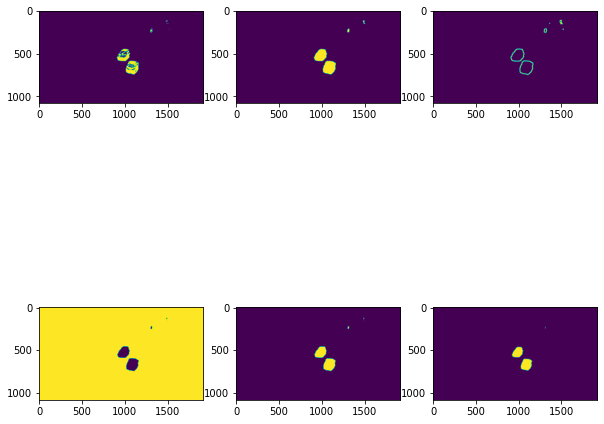

In [14]:
fig, ax = plt.subplots(2,3, figsize=(10,10))
ax[0][0].imshow(threshold)
ax[0][1].imshow(closing)
ax[0][2].imshow(gradient)
ax[1][0].imshow(flood)
ax[1][1].imshow(invert)
ax[1][2].imshow(test)

output the result

In [ ]:
output_array = processed_masks

out = cv.VideoWriter('/content/drive/MyDrive/vision/foreground.mp4',cv.VideoWriter_fourcc(*'DIVX'), capture.get(5), (int(capture.get(3)),int(capture.get(4))))
shape = (masks[0].shape[0], masks[0].shape[1], 3)
for i in range(len(output_array)):
    # writing to a image array
    mask_corrected = cv.cvtColor(output_array[i], cv.COLOR_GRAY2RGB)
    out.write(mask_corrected)
    del mask_corrected
    if i%100 == 0:
      print('processed frame ', i)

out.release()

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/vision/foreground.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# KNN

Read video and create foreground masks using a different mog method. Save video frames and masks in arrays.

In [4]:
masks = []
frames = []

backSub = cv.createBackgroundSubtractorKNN(30, 2000, False)
capture = cv.VideoCapture(video_path)
if not capture.isOpened():
    print('Unable to open video')
asd = 0
limit_frames = True #collect only a part of the video, used to save time during testing

while True:
    asd +=1
    if(asd%100 == 0):
      print('processed frame ', asd)
    if (asd==300) and limit_frames:
      print('gathered enough frames, exiting')
      break
    ret, frame = capture.read()
    if frame is None:
        break
    frame = cv.GaussianBlur(frame,(5,5),0)
    foregroundMask = backSub.apply(frame)
    # frames.append(frame)
    masks.append(foregroundMask)

processed frame  100
processed frame  200
processed frame  300
gathered enough frames, exiting


Apply processing to the foreground masks to fill holes and reduce noise.

In [6]:

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(30,30))
gradient_kernel = cv.getStructuringElement(cv.MORPH_RECT,(30,30))
gradient_kernel2 = cv.getStructuringElement(cv.MORPH_RECT,(30,30))
erode_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(30,30))
threshold_value = 50
new_masks = []
asd = 0
for mask in masks:
  asd += 1
  if asd%100==0:
    print('processed ', asd)

  new_mask = cv.GaussianBlur(mask,(5,5),0)
  new_mask = cv.threshold(new_mask, threshold_value, 255, cv.THRESH_BINARY)
  new_mask = new_mask[1]
  closing = cv.morphologyEx(new_mask, cv.MORPH_CLOSE, kernel)

  gradient = cv.morphologyEx(closing, cv.MORPH_GRADIENT, gradient_kernel)

  thresh = cv.threshold(gradient, 50, 255, cv.THRESH_BINARY)
  thresh = thresh[1]
  flood = cv.floodFill(thresh, None, (0,0), 255)
  flood = flood[1]
  invert = cv.bitwise_not(flood)
  combine = gradient | invert

  test_grad = cv.morphologyEx(combine, cv.MORPH_GRADIENT, gradient_kernel2)
  test = cv.bitwise_and(combine, cv.bitwise_not(test_grad))
  test = cv.erode(test, erode_kernel)

  new_masks.append(test)

processed  100
processed  200


this cell is used for testing and visualizing results

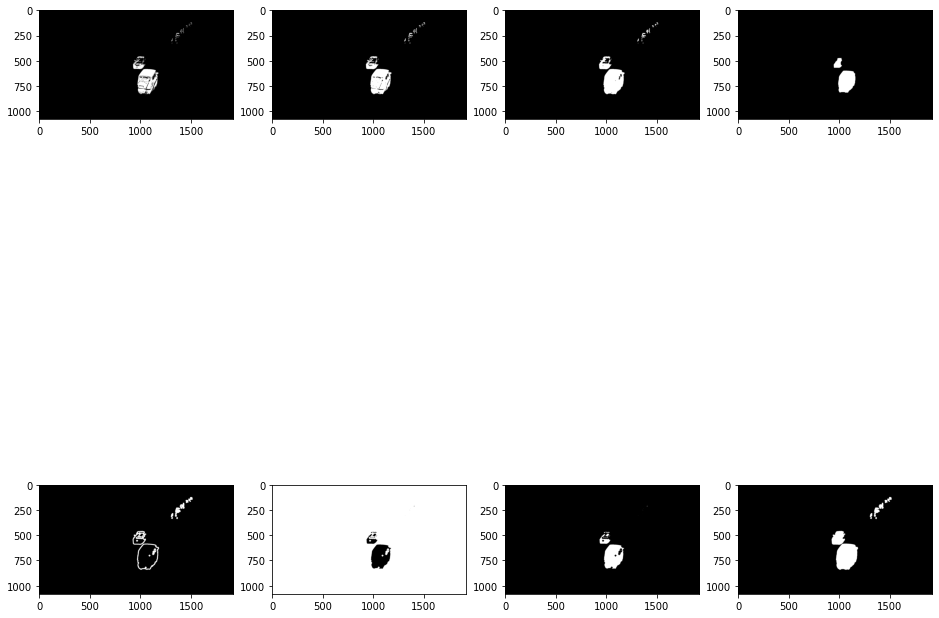

In [17]:
mask = masks[496]
kernel = cv.getStructuringElement(cv.MORPH_CROSS,(10,10))
gradient_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
gradient_kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
erode_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(30,30))
threshold_value = 50

new_mask = cv.GaussianBlur(mask,(5,5),0)
new_mask = cv.threshold(new_mask, threshold_value, 255, cv.THRESH_BINARY)
new_mask = new_mask[1]
closing = cv.morphologyEx(new_mask, cv.MORPH_CLOSE, kernel)

gradient = cv.morphologyEx(closing, cv.MORPH_GRADIENT, gradient_kernel)

thresh = cv.threshold(gradient, 50, 255, cv.THRESH_BINARY)
thresh = thresh[1]
flood = cv.floodFill(thresh, None, (0,0), 255)
flood = flood[1]
invert = cv.bitwise_not(flood)
combine = gradient | invert

test_grad = cv.morphologyEx(combine, cv.MORPH_GRADIENT, gradient_kernel2)
test = cv.bitwise_and(combine, cv.bitwise_not(test_grad))
test = cv.erode(test, erode_kernel)


fig, ax = plt.subplots(2,4,figsize=(16,16))
ax[0][0].imshow(mask, cmap='gray')
ax[0][1].imshow(new_mask, cmap='gray')
ax[0][2].imshow(closing, cmap='gray')
ax[0][3].imshow(test, cmap='gray')
ax[1][0].imshow(gradient, cmap='gray')
ax[1][1].imshow(flood, cmap='gray')
ax[1][2].imshow(invert, cmap='gray')
ax[1][3].imshow(combine, cmap='gray')

produce output

In [19]:
output_array = new_masks

out = cv.VideoWriter('/content/drive/MyDrive/vision/erodedKNN.mp4',cv.VideoWriter_fourcc(*'DIVX'), capture.get(5), (int(capture.get(3)),int(capture.get(4))))
shape = (masks[0].shape[0], masks[0].shape[1], 3)
for i in range(len(output_array)):
    # writing to a image array
    mask_corrected = cv.cvtColor(output_array[i], cv.COLOR_GRAY2RGB)
    out.write(mask_corrected)
    del mask_corrected
    if i%100 == 0:
      print('processed frame ', i)

out.release()

files.download('/content/drive/MyDrive/vision/erodedKNN.mp4')

processed frame  0
processed frame  100
processed frame  200
processed frame  300
processed frame  400
processed frame  500
processed frame  600
processed frame  700
processed frame  800
processed frame  900
processed frame  1000
processed frame  1100


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# frame difference

In [19]:
video_path = '/content/drive/MyDrive/vision/senza_ombre_motog5.mp4'
cap = cv.VideoCapture(video_path)
processed_frames = []
index = 0
masks = []

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(30,30))
gradient_kernel = cv.getStructuringElement(cv.MORPH_RECT,(30,30))
erode_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
threshold_value = 100

while cap.isOpened():
  ret, frame_current = cap.read()
  ret_next, frame_next = cap.read()
  if not ret or not ret_next:
    print("Can't receive frame (stream end?). Exiting ...")
    break

  processed_frames.append(frame_current)

  gray_current = cv.cvtColor(frame_current, cv.COLOR_BGR2GRAY)
  gray_next = cv.cvtColor(frame_next, cv.COLOR_BGR2GRAY)
  difference = cv.absdiff(gray_current, gray_next)
  blur = cv.GaussianBlur(difference,(5,5),0)
  thresh = cv.threshold(blur, threshold_value, 255, cv.THRESH_BINARY)
  thresh = thresh[1]
  closing = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
  gradient = cv.morphologyEx(closing, cv.MORPH_GRADIENT, gradient_kernel)
  thresh = cv.threshold(gradient, 50, 255, cv.THRESH_BINARY)
  thresh = thresh[1]
  flood = cv.floodFill(thresh, None, (0,0), 255)
  flood = flood[1]
  invert = cv.bitwise_not(flood)
  combine = gradient | invert
  masks.append(combine)


Can't receive frame (stream end?). Exiting ...


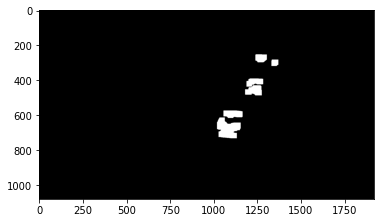

In [23]:
plt.imshow(masks[200], cmap='gray')